# Logistic Regression (Advanced Example)
Here's an example of the famous Titanic dataset, it's always nice to start off with this dataset because it is an example you will find across most data analysis languages.

Objective: For this exercise, our aim is to find out if a passenger on the Titanic is likely to survive or die based on their features. 

In [2]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import *
spark = SparkSession.builder.appName('logistic_regression_adv').getOrCreate()

# If you're getting an error with numpy, please type 'sudo pip install numpy --user' into the EC2 console.
from pyspark.ml.classification import LogisticRegression

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/31 02:47:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read in the CSV data.
data = spark.read.csv('Datasets/titanic_data.csv',inferSchema=True,header=True)

In [4]:
# Print data schema.
data.printSchema()

# Print data columns.
data.columns

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [5]:
# Select a list of relevant columns. 
# Name, for example, is somewhat irrelevant.
my_cols = data.select(['Survived',
 'Pclass',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Embarked'])

In [6]:
# Now that we've selected the relevant columns, let's drop the missing data.
my_final_data = my_cols.na.drop()

## Working with Categorical Columns

While continuous features are simple to use, what if a feature in your data uses the words male and female to describe gender? Generally, these categories should be converted to a number so that they can be utilised effectively.

Let's break this down into multiple steps to make it all clear.

In [7]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer)

In [8]:
# First create a string indexer (convert every string into a number, such as male = 0 and female = 1).
# A number will be assigned to every category in the column.
gender_indexer = StringIndexer(inputCol='Sex',outputCol='SexIndex')

# Now we can one hot encode these numbers. This converts the various outputs into a single vector.
# This makes it easier to process when you have multiple classes.
gender_encoder = OneHotEncoder(inputCol='SexIndex',outputCol='SexVec')

In [9]:
# Similar to the above.
embark_indexer = StringIndexer(inputCol='Embarked',outputCol='EmbarkIndex')
embark_encoder = OneHotEncoder(inputCol='EmbarkIndex',outputCol='EmbarkVec')

In [10]:
# Now we can assemble all of this as one vector in the features column. 
assembler = VectorAssembler(inputCols=['Pclass',
 'SexVec',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'EmbarkVec'],outputCol='features')

In [11]:
from pyspark.ml.classification import LogisticRegression

## Pipelines 

A pipeline sets stages for different steps. Let's see an example of how to use pipelines.

In [12]:
from pyspark.ml import Pipeline

In [13]:
# Note that survived is a categorial variable but didn't require any transformation.
# That's because it's already in the format of 1's and 0's. 
log_reg_titanic = LogisticRegression(featuresCol='features',labelCol='Survived')

In [14]:
# Lists everything we want to do. Index data, encode data, assemble data and then pass in the actual model.
pipeline = Pipeline(stages=[gender_indexer,embark_indexer,
                           gender_encoder,embark_encoder,
                           assembler,log_reg_titanic])

In [15]:
# Train/test split. 
train_titanic_data, test_titanic_data = my_final_data.randomSplit([0.7,.3])

In [16]:
# Note pipeline. Call it as you would call a machine learning object.
fit_model = pipeline.fit(train_titanic_data)

22/05/31 02:48:05 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/05/31 02:48:05 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [17]:
# Transform test data. 
results = fit_model.transform(test_titanic_data)

In [18]:
# Evaluate the model using the binary classifer.
from pyspark.ml.evaluation import BinaryClassificationEvaluator

my_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='Survived')

In [19]:
# If we select the actual and predicted results, we can see that some predictions were correct while others were wrong.
results.select('Survived','prediction').show()

+--------+----------+
|Survived|prediction|
+--------+----------+
|       0|       1.0|
|       0|       1.0|
|       0|       1.0|
|       0|       1.0|
|       0|       1.0|
|       0|       0.0|
|       0|       1.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
+--------+----------+
only showing top 20 rows



In [20]:
# We can then evaluate using AUC (area under the curve). AUC is linked to ROC.
AUC = my_eval.evaluate(results)

AUC

0.7891472868217053

## Data Visualisation

PySpark doesn't allow you to plot data directly. Instead, the simplest way to visualise data is to convert the DataFrame into an array, then use Python's extensive libraries (such as Matplotlib) to visualise the data appropriately. Because of this, the sky's the limit when it comes to data visualisation! Here's a simple example:

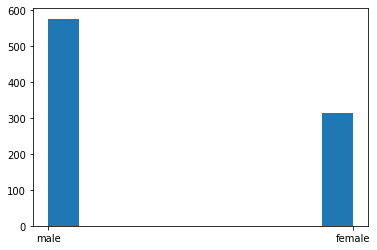

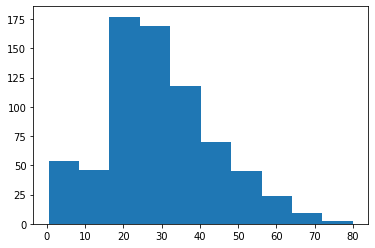

In [21]:
# Import the relevant Python libraries.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Convert sex to an array using Numpy and plot it using pyplot. 
sexArr = np.array(data.select('Sex').collect())
plt.hist(sexArr)
plt.show()

# Because you can interact with Spark using SQL, you can also filter the data you see. 
# For example, age has some null values. We can remove all null values before visualising the data.
ageArr = np.array(data.filter('Age > 0').select('Age').collect())
plt.hist(ageArr)
plt.show()

## Other Forms of Interpretation

In [22]:
# Not all interpretation has to be visualisations. You can also gain a lot of information with text.
# For example, here we're seeing how much variance our model could account for.
# According to this, the model got 164/209 correct. 
totalResults = results.select('Survived','prediction')

correctResults = totalResults.filter(totalResults['Survived'] == totalResults['prediction'])

countTR = totalResults.count()
print("Correct: " + str(countTR))

countTC = correctResults.count()
print("Total Correct: " + str(countTC)) 

Correct: 219
Total Correct: 175
